In [1]:
import matplotlib.pyplot as plt
def plot_hist(
        targets,
        expected_values,
        y_pred_upper,
        y_pred_lower,
        analyzed_metrics=["mse"],
        sample_frequency=1,
        save_to_disc=False,
        fig_title="Error Probability Distribution",
        method="method",
        bins=10,
):
    """
    Create a matplotlib.pyplot.figure with kde plots for the given metrics
    Save the resulting figure at (save_to_disc + 'Error Probability Distribution')
    To visualize more clearly a sampling frequency can be defined,
    i.e. the time-delta of the moving windows over the test set.
    Per default over the test set, every timestep initiates a new out-of-sample prediction.
    E.g. if the evaluations hall happen on daily basis with hourly time steps sample_frequency can be set to 24.

    Parameters
    ----------
    TODO

    Returns
    -------
    No return value
    """
    metrics_per_sample = {}
    for results in range(targets.shape[0]):
        mse_per_sample = [
            metrics.mse(targets[results][i], [expected_values[results][i]])
            for i, value in enumerate(targets[results])
        ]
        metrics_per_sample[results] = pd.DataFrame(data=mse_per_sample, columns=['mse']).astype("float")
        residuals_per_sample = [
            metrics.residuals(targets[results][i], [expected_values[results][i]])
            for i, value in enumerate(targets[results])
        ]
        metrics_per_sample[results]["residuals"] = pd.DataFrame(residuals_per_sample).astype("float")
    all_results = pd.concat(
        metrics_per_sample.values(),
        keys=metrics_per_sample.keys(),
        axis=1
    )
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(24, 12))  # plt.figure()
        results = pd.DataFrame(data=all_results.xs('residuals', axis=1, level=1, drop_level=False).values, columns=method)
        #print("Residuals DataFrame Head:",results.head())
        for element in results:
            if element in ['SARIMAX', 'naive-stl', 'seasonal-naive', 'RNN']:
                ax1 = results[element].plot(kind='hist',bins=bins,alpha=0.8, label = element)
                ax1.set_title('Histogram of Residuals', fontsize=30)
                ax1.set_xlabel('Residuals', fontsize=30)
                ax1.set_ylabel('Frequency', fontsize=30)
                ax1.legend(fontsize=26, loc='upper left', fancybox=True)
        ax1.tick_params(axis='both', which='major', labelsize=30, color = 'b')
        if save_to_disc:
            plt.savefig(save_to_disc + fig_title + '.png')
        plt.show()

In [2]:
import os
import sys
sys.path.append("../")
import argparse

import pandas as pd
import torch
import utils.plot as plot
import os

import utils.datahandler as dh
import utils.metrics as metrics
import utils.baselinehandler as baselines

from utils.confighandler import read_config
from utils.cli import parse_with_loss

In [3]:
config_path = 'opsd_24'
PAR = read_config(config_path, main_path="../")
model_name = PAR["model_name"]
data_path = PAR["data_path"]

INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

SCALE_DATA = True
LIMIT_HISTORY = 336
SLIDING_WINDOW = 1
DAY_FIRST = True
ORDER = (3, 1, 0)
sORDER = (2, 0, 0, 24)
SEASONALITY=24
PERIODICITY=7
ALPHA = 1.96
EXOG = True
APPLY_EXISTING_MODEL = False

arima_order = ORDER
sarima_order = ORDER
sarima_sorder = sORDER

DEVICE = "cpu"

torch.set_printoptions(linewidth=120) # Display option for output
torch.set_grad_enabled(True)

In [4]:
PAR

{'data_path': './data/opsd.csv',
 'output_path': './oracles/',
 'exploration_path': './targets/opsd_24/tuning.json',
 'evaluation_path': './oracles/eval_opsd_24/',
 'log_path': './logs/',
 'model_name': 'opsd_24_LSTM_gnll',
 'target_id': ['DE_load_actual_entsoe_transparency'],
 'target_list': None,
 'start_date': None,
 'history_horizon': 147,
 'forecast_horizon': 24,
 'cap_limit': 1,
 'train_split': 0.6,
 'validation_split': 0.8,
 'core_net': 'torch.nn.LSTM',
 'optimizer_name': 'adam',
 'exploration': True,
 'relu_leak': 0.1,
 'cuda_id': None,
 'feature_groups': [{'name': 'main',
   'scaler': ['minmax', -1.0, 1.0],
   'features': ['AT_load_actual_entsoe_transparency',
    'DE_load_actual_entsoe_transparency',
    'AT_temperature',
    'AT_radiation_direct_horizontal',
    'AT_radiation_diffuse_horizontal',
    'DE_temperature',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal']},
  {'name': 'aux',
   'scaler': None,
   'features': ['hour_0',
    'hour_1',
   

In [5]:
def eval_baseline(config, mean_forecast, df_target, upper_PI, lower_PI, load_limit, hours, path, baseline_method='baseline', analyzed_metrics=["mse"],
                  forecast_horizon=1, anchor_adjustment =0):
    """
    Evaluate a baseline forecast using several different metrics and plot the results.

    A non-zero value for anchor_adjustment can additionally adjust benchmark forecasts to the
    forecast start time of the ProLoaF RNN method, to facilitate the comparison of sample days

    Parameters
    ----------
    mean_forecast : array-like
        Contains forecasted expected values
    df_target : array-like
        The reference or measured target variable
    upper_PI : array-like
        Upper prediction interval
    lower_PI : array-like
        Lower prediction interval
    load_limit : float
        The cap limit
    hours : array-like
        The actual time from the data set
    baseline_method : string, default = 'baseline'
        The text for the title of the plot
    forecast_horizon : int, default = 1
        Number of future steps to be forecasted
    anchor_adjustment : int, default = 0
        A positive value which is subtracted from the standard evaluation hours (0, 12, 24,
        48, 100, and 112), enabling hours at a fixed offset from the standard ones to be
        evaluated. I.e.:
        - For anchor_adjustment = 3, evaluate forecasts for hours 9, 21, 45, 97, and 109
    """
    #forecasts,
    # endog_val,
    # upper_limits,
    # lower_limits,
    # model_name,
    # path,
    # config,
    # analyzed_metrics
    return baselines.eval_forecast(
        forecasts=mean_forecast,
        endog_val=df_target,
        upper_limits=upper_PI,
        lower_limits=lower_PI,
        model_name=baseline_method,
        path=path,
        config=config,
        analyzed_metrics=analyzed_metrics)

### Read load data and set frequency and timestamps
We set the frequency of timesteps to hours. This frequency of the dataframe is e.g. used in the naive seasonal decomposition forecast model.

We take all features into consideration that have been categorized as either encoder or decoder feature. We will then only take those different from the endogeneous feature. So here we need to remove the target (=endogenous) feature.

In [6]:
df = pd.read_csv(INFILE, sep=';',index_col=0)
dh.fill_if_missing(df, periodicity=SEASONALITY)
df = df.asfreq(freq='H')

time_delta = pd.to_datetime(df.index[1]) - pd.to_datetime(df.index[0])
timestamps = pd.date_range(start=pd.to_datetime(df.index, dayfirst=DAY_FIRST)[0],
                      end=pd.to_datetime(df.index, dayfirst=DAY_FIRST)[-1],
                      freq=str(time_delta.seconds / 3600) + 'H')
df.index = timestamps

if ('col_list' in PAR):
    if(PAR['col_list'] != None):
        df[target_id] = df[PAR['col_list']].sum(axis=1)

target = PAR['target_id']
enc_features = PAR['encoder_features']
dec_features = PAR['decoder_features']

#now just make sure that the exogenous features do not include the target itself as endog already does.
if target in enc_features: enc_features.remove(target)
if target in dec_features: dec_features.remove(target)

No missing data 



### Now the data shall be scaled and split according to the scalers and train-test split defined in the config

In [7]:
if SCALE_DATA:
    df, _ = dh.scale_all(df, **PAR)

df_train = df.iloc[:int(PAR['validation_split'] * len(df))]
df_val = df.iloc[int(PAR['validation_split'] * len(df)):]

Lets checkout which endog and exog features we are dealing with:

In [8]:
display(df_train)

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_0,hour_1,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2014-12-31 23:00:00,0.041917,-0.574240,-0.557967,-1.000000,-1.000000,-0.512260,-1.000000,-1.000000,0,0,...,0,0,1,0,0,1,0,0,0,0
2015-01-01 00:00:00,0.041917,-0.574240,-0.558285,-1.000000,-1.000000,-0.513962,-1.000000,-1.000000,1,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 01:00:00,-0.001479,-0.618183,-0.556494,-1.000000,-1.000000,-0.516205,-1.000000,-1.000000,0,1,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 02:00:00,-0.076240,-0.662688,-0.548331,-1.000000,-1.000000,-0.519277,-1.000000,-1.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 03:00:00,-0.095572,-0.677436,-0.534593,-1.000000,-1.000000,-0.521644,-1.000000,-1.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 14:00:00,0.317881,-0.130012,-0.263782,-0.991061,-0.825684,-0.252860,-0.998857,-0.895807,0,0,...,0,0,1,1,0,0,0,0,0,0
2018-12-31 15:00:00,0.363448,-0.049479,-0.316623,-0.999958,-0.997092,-0.276446,-0.999967,-0.995226,0,0,...,0,0,1,1,0,0,0,0,0,0
2018-12-31 16:00:00,0.413157,0.060594,-0.331395,-1.000000,-1.000000,-0.275324,-1.000000,-1.000000,0,0,...,0,0,1,1,0,0,0,0,0,0
2018-12-31 17:00:00,0.393629,0.045889,-0.334700,-1.000000,-1.000000,-0.272708,-1.000000,-1.000000,0,0,...,0,0,1,1,0,0,0,0,0,0


Here we do not use torch tensors. But we apply a similar tranform just as it is done, with dh.tranform, resulting in pandas dataframes for the input and putput vaues on the train and validation set. Some of the baseline methods, only work with 1D arrays insteag of dataframes. We create the datastructures for both purposes here:

In [9]:
x_train = dh.extract(df_train.iloc[:-PAR['forecast_horizon']], PAR['forecast_horizon'])
x_val = dh.extract(df_val.iloc[:-PAR['forecast_horizon']], PAR['forecast_horizon'])
y_train = dh.extract(df_train.iloc[PAR['forecast_horizon']:], PAR['forecast_horizon'])
y_val = dh.extract(df_val.iloc[PAR['forecast_horizon']:], PAR['forecast_horizon'])

target_column = df.columns.get_loc(target[0])

x_train_1D = x_train[:,:,target_column]
x_val_1D = x_val[:,:,target_column]
y_train_1D = y_train[:,:,target_column]

We want to fill step by step empty arrays with the expected values and prediction intervales, computed from each of the following baseline models. The array baseline_method will contain the names of the computed methods, which will serve as labels lateron in the benchmark step.

In [10]:
mean_forecast = []
upper_PI = []
lower_PI = []
baseline_method = []

### We will generate exogenous variables already now for some of the baseline methods that make use of them.

In [11]:
df_exog_train = df_train[enc_features+dec_features]
df_exog_val = df_val[enc_features+dec_features]

### <u>Baseline model1</u>:   Naive Persistence model

In [12]:
naive_expected_values, naive_y_pred_upper, naive_y_pred_lower = baselines.persist_forecast(x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], alpha=ALPHA)
mean_forecast.append(naive_expected_values)
upper_PI.append(naive_y_pred_upper)
lower_PI.append(naive_y_pred_lower)
baseline_method.append('simple-naive')

Train a naive (persistence) timeseries model...
Training and validating naive (persistence) model completed.


### <u>Baseline model2</u>: Seasonal Naive

* <u>**Major difference from the persistence model**</u>: Instead of forecasting last observed value for the entire horizon, it considers the <u>**previous day's value for each corresponding hour in the forecast horizon.**</u>
* Lets call it the periodic model. 

In [13]:
# SNaïve
s_naive_expected_values, s_naive_y_pred_upper, s_naive_y_pred_lower = baselines.seasonal_forecast(x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], PERIODICITY, alpha=ALPHA)
mean_forecast.append(s_naive_expected_values)
upper_PI.append(s_naive_y_pred_upper)
lower_PI.append(s_naive_y_pred_lower)
baseline_method.append('seasonal-naive')

Train a seasonal naive timeseries model with seasonality= 1 ...
Training and validating seasonal naive model completed.


### <u>Baseline model3</u>: Seasonally Decomposed Naive

In [14]:
# Decomposition(+ any#model)
sd_naive_expected_values, sd_naive_y_pred_upper, sd_naive_y_pred_lower = baselines.persist_forecast(x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'],periodicity=PERIODICITY, seasonality=SEASONALITY,decomposed=True, alpha=ALPHA)
mean_forecast.append(sd_naive_expected_values)
upper_PI.append(sd_naive_y_pred_upper)
lower_PI.append(sd_naive_y_pred_lower)
baseline_method.append('naive-stl')

Train a naive timeseries model cleared with seasonal decomposition (STL)...
Training and validating naive (STL) completed.


In [15]:
NUM_PRED = len(df_val[target])

We let the ARIMA models refit over the validation set. That is why we fetch NUM_Pred from the dataframe now.

### <u>Baseline model4</u>: ARIMA

In [16]:
#baselines.test_stationarity(df_train[target],maxlag=PERIODICITY*SEASONALITY)
###############################ARIMA####################################
arima_model=None
if(APPLY_EXISTING_MODEL): arima_model = baselines.load_baseline(OUTDIR,name='ARIMA')
if arima_model == None:
    arima_model,_,_,arima_order,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=None,
        seasonal = False,
        lag=PERIODICITY*SEASONALITY,
        grid_search = PAR['exploration'],
        train_limit=LIMIT_HISTORY
    )
else: print('Loaded existing fitted ARIMA model from ',OUTDIR)
baselines.save_baseline(OUTDIR, arima_model, name='ARIMA',  save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  336
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-971.005, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-596.707, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-916.280, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-859.908, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-596.707, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-977.511, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-978.847, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-977.468, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-975.602, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-978.847, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.029 seconds

### <u>Baseline model5</u>: SARIMA

In [17]:
##############################SARIMA####################################
sarima_model=None
if(APPLY_EXISTING_MODEL): sarima_model = baselines.load_baseline(OUTDIR,name='SARIMA')
if sarima_model == None:
    sarima_model,_,_,sarima_order,sarima_sorder = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=sORDER,
        seasonal = True,
        lag=PERIODICITY*SEASONALITY,
        m=SEASONALITY,
        train_limit=LIMIT_HISTORY,
        grid_search = PAR['exploration']
    )
else: print('Loaded existing fitted SARIMA model from ',OUTDIR)
baselines.save_baseline(OUTDIR, sarima_model, name='SARIMA', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  336
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=-1134.058, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-596.707, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-1058.891, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-596.707, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-971.005, Time=0.20 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=-1339.344, Time=1.30 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=-1325.072, Time=1.11 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=-1336.902, Time=11.06 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=-1337.644, Time=11.13 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=-1209.493, Time=7.51

/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving fitted sarimax model


### <u>Baseline model6</u>: ARIMAX

In [18]:
###############################ARIMAX####################################
arimax_model = None
if(APPLY_EXISTING_MODEL): arimax_model = baselines.load_baseline(OUTDIR, name='ARIMAX')
if arimax_model == None:
    arimax_model,_,_,_,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=arima_order,
        seasonal_order=None,
        seasonal=False,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY*SEASONALITY,
        grid_search=False
    )
else: print('Loaded existing fitted ARIMAX model from ',OUTDIR)
baselines.save_baseline(OUTDIR, arimax_model, name='ARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  336
Train ARIMAX with order: (2, 1, 0)
Saving fitted sarimax model


### <u>Baseline model7</u>: SARIMAX

In [19]:
###############################SARIMAX###################################
sarimax_model = None
if (APPLY_EXISTING_MODEL): sarimax_model = baselines.load_baseline(OUTDIR, name='SARIMAX')
if sarimax_model == None:
    sarimax_model, _, _, _, _ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=sarima_order,
        seasonal_order=sarima_sorder,
        seasonal=True,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY * SEASONALITY,
        m=SEASONALITY,
        grid_search=False
    )
else:
    print('Loaded existing fitted SARIMAX model from ', OUTDIR)
baselines.save_baseline(OUTDIR, sarimax_model, name='SARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  336
Train SARIMAX with order: (2, 1, 0)  and seasonal order: (1, 0, 1, 24)


/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving fitted sarimax model


#### Only fetch predictions of that ARMA Model, that has the lowest AIC, since making forecasts on the whole validation set causes a high memory comsuming effort

In [20]:
list_of_models = [arima_model, sarima_model, arimax_model, sarimax_model]
arima_models = pd.DataFrame(data=[arima_model.aic, sarima_model.aic, arimax_model.aic, sarimax_model.aic], index=["ARIMA","SARIMA","ARIMAX","SARIMAX"], columns = {"AIC"})
print(arima_models)

min_index = arima_models.index.get_indexer(arima_models[arima_models["AIC"] == arima_models["AIC"].min()].index)[0]
print(arima_models[arima_models["AIC"] == arima_models["AIC"].min()])
best_arima_model = list_of_models[min_index]

                 AIC
ARIMA    -978.846830
SARIMA  -1347.695890
ARIMAX   -980.776379
SARIMAX -1349.237338
                 AIC
SARIMAX -1349.237338


In [21]:
ARIMA_expected_values, ARIMA_y_pred_upper, ARIMA_y_pred_lower = \
    baselines.make_forecasts(
        endog_train = df_train[target],
        endog_val = df_val[target],
        fitted = best_arima_model,
        forecast_horizon = PAR['forecast_horizon'],
        train_limit = LIMIT_HISTORY,
        limit_steps = NUM_PRED,
        pi_alpha = ALPHA,
        online = True)

mean_forecast.append(ARIMA_expected_values)
upper_PI.append(ARIMA_y_pred_upper)
lower_PI.append(ARIMA_y_pred_lower)
baseline_method.append(["ARIMA","SARIMA","ARIMAX","SARIMAX"][min_index])

print("Best Arima Model is the trained: ",baseline_method[-1:][0])

Added re-training set too long for SARIMAX model. SARIMAX does not improve with very long training sets. Set re-training set to latest:  336  entries
Predictions made without exogenous variables
Training and validating (S)ARIMA(X) completed.
Best Arima Model is the trained:  SARIMAX


### <u>Baseline model8</u>: ETS (Exponential Smoothing Model)

In [22]:
# Exponential smoothing
#with contextlib.redirect_stdout(None):
train=pd.Series(df_train[target].values.squeeze(), index=df_train[target].index)
test=pd.Series(df_val[target].values.squeeze(), index=df_val[target].index)
ets_expected_values, ets_y_pred_upper, ets_y_pred_lower = \
    baselines.exp_smoothing(train, test, PAR['forecast_horizon'],
                            limit_steps=NUM_PRED, online = False)
mean_forecast.append(ets_expected_values)
upper_PI.append(ets_y_pred_upper)
lower_PI.append(ets_y_pred_lower)
baseline_method.append('ets')

Train an exponential smoothing timeseries model (ETS)...
Training and validating ETS model completed.


### <u>Baseline model10</u>: GARCH
Last but not least we add one baseline method from the econometrics field that is capable of generating conditional prediction intervals, given the heteroscedastic (varying standard deviation) character of the underlying timeseries

In [23]:
#GARCH
mean = None
p = 1
q = 1
# e.g. Garch (p'=1,q'=1) has the Arch order 1(past residuals squared) and the Garch order 1(past variance:=sigma^2)
# in comparison, ARMA (p=1,p=1) has AR order 1(past observations) and MA order 1(past residuals)
# --> this is why we just use the computed mean by sarimax (called SARIMAX_expected_values here)
# why not more than one Garch component? when forecasting market returns e.g.,
# all the effects of conditional variance of t-2 are contained in the conditional variance t-1
# p: is arch order and q ist garch order
# arch component is nearly equivalent to the MA component of SARIMAX_expected_values here --> p' = q
# garch component is nearly equivalent to the AR component of SARIMAX -->q'= p
mean = ARIMA_expected_values
GARCH_expected_values, GARCH_y_pred_upper, GARCH_y_pred_lower = \
    baselines.GARCH_predictioninterval(df_train[target], df_val[target], PAR['forecast_horizon'],
                                       mean_forecast=mean, p=p, q=q, alpha=ALPHA, limit_steps=NUM_PRED,
                                       periodicity=PERIODICITY)
mean_forecast.append(mean)
upper_PI.append(GARCH_y_pred_upper)
lower_PI.append(GARCH_y_pred_lower)
baseline_method.append('garch')

Train a General autoregressive conditional heteroeskedasticity (GARCH) model...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13369.314545359037
            Iterations: 16
            Function evaluations: 93
            Gradient evaluations: 16
Training and validating GARCH model completed.


### Now we move to the evaluation step to compare the fitted models on new data
We determine a set of metrics that we are interested in:

In [24]:
analyzed_metrics = [
    "mse",
    "rmse",
    "sharpness",
    "picp",
    "rae",
    "mae",
    "mis",
    "qs",
    "residuals"
]

In [25]:
baseline_method

['simple-naive', 'seasonal-naive', 'naive-stl', 'SARIMAX', 'ets', 'garch']

Lets create some empty variables to fill in the following loop over mean foreacasts

In [26]:
results=pd.DataFrame(index=analyzed_metrics)
results_per_timestep = {}
true_values= torch.zeros([len(mean_forecast), NUM_PRED, PAR['forecast_horizon']])
forecasts=torch.zeros([len(mean_forecast), NUM_PRED, PAR['forecast_horizon']])
upper_limits=torch.zeros([len(mean_forecast), NUM_PRED, PAR['forecast_horizon']])
lower_limits=torch.zeros([len(mean_forecast), NUM_PRED, PAR['forecast_horizon']])

In [27]:
true_values= torch.zeros([len(mean_forecast), 8718, PAR['forecast_horizon']])
forecasts=torch.zeros([len(mean_forecast), 8718, PAR['forecast_horizon']])
upper_limits=torch.zeros([len(mean_forecast), 8718, PAR['forecast_horizon']])
lower_limits=torch.zeros([len(mean_forecast), 8718, PAR['forecast_horizon']])

We need to differentiate the length of the inout data to each model depending on the chosen baseline method. This is done in the following:

Calling Baseline Evaluation for Method: simple-naive


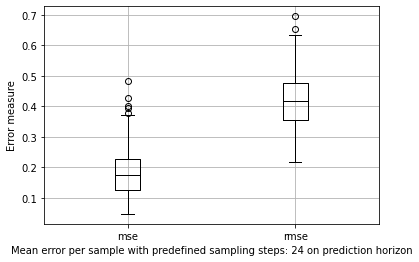

Calling Baseline Evaluation for Method: seasonal-naive


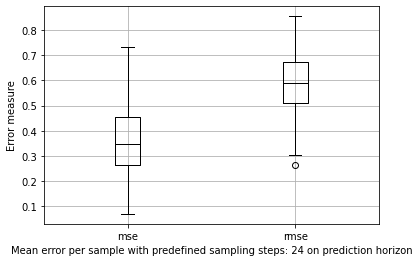

Calling Baseline Evaluation for Method: naive-stl


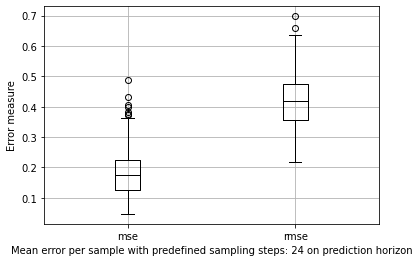

Calling Baseline Evaluation for Method: SARIMAX


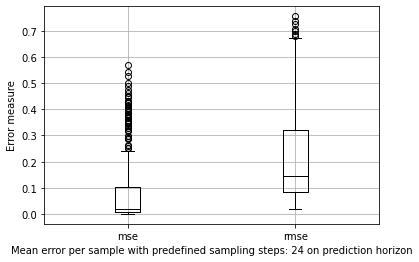

Calling Baseline Evaluation for Method: ets


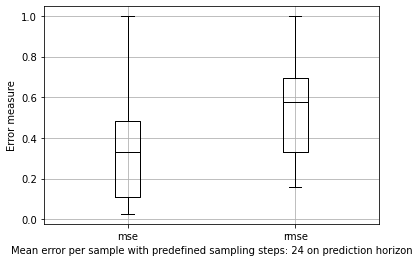

Calling Baseline Evaluation for Method: garch


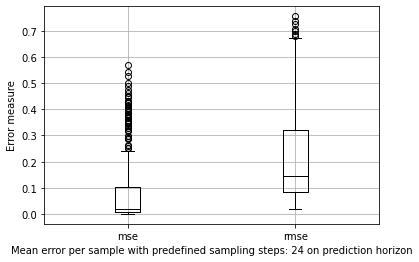

In [28]:
#==========================Evaluate ALL==========================
for i, forecast in enumerate(mean_forecast):
    print('Calling Baseline Evaluation for Method:', baseline_method[i])
    if len(forecast) - PAR['forecast_horizon'] == len(y_val):
        results[baseline_method[i]], results_per_timestep[baseline_method[i]], true_values[i],forecasts[i],upper_limits[i],lower_limits[i] = \
            eval_baseline(
                config=PAR,
                mean_forecast=forecast[PAR['forecast_horizon']:PAR['forecast_horizon']+NUM_PRED],
                df_target=y_val[:NUM_PRED,:,target_column],
                upper_PI=upper_PI[i][PAR['forecast_horizon']:PAR['forecast_horizon']+NUM_PRED,:],
                lower_PI=lower_PI[i][PAR['forecast_horizon']:PAR['forecast_horizon']+NUM_PRED,:],
                load_limit=PAR['cap_limit'],
                hours = pd.to_datetime(df_val[PAR['forecast_horizon']:].index).to_series(),
                path=OUTDIR,
                baseline_method='test_'+baseline_method[i],
                forecast_horizon= PAR['forecast_horizon'],
                analyzed_metrics=analyzed_metrics,
            )
    else:
        results[baseline_method[i]], results_per_timestep[baseline_method[i]], true_values[i],forecasts[i],upper_limits[i],lower_limits[i] = \
            eval_baseline(
                config=PAR,
                mean_forecast=forecast[:NUM_PRED],
                df_target=y_val[:NUM_PRED, :, target_column],
                upper_PI=upper_PI[i][:NUM_PRED],
                lower_PI=lower_PI[i][:NUM_PRED],
                load_limit=PAR['cap_limit'],
                hours=pd.to_datetime(df_val.index).to_series(),
                path=OUTDIR,
                baseline_method='test_'+baseline_method[i],
                forecast_horizon=PAR['forecast_horizon'],
                analyzed_metrics=analyzed_metrics,
            )

One issue with the above code is that the results per timestep per baseline, are as many values as predictions steps we have, evaluated for multiple metrics and multiple baselne methods. We now merge all the information into a multi-index, multi-column pandas dataframe for the plotting fuctions lateron

In [29]:
results_per_timestep_per_baseline = pd.concat(
    results_per_timestep.values(),
    keys=results_per_timestep.keys(),
    axis=1
)
results_per_timestep_per_baseline.head()

simple-naive                                          seasonal-naive  \
           mse      rmse sharpness       picp       mis            mse   
0     0.011967  0.109394  0.444612  95.056206  0.592892       0.270240   
1     0.042789  0.206856  0.841381  94.689148  1.081583       0.270294   
2     0.085222  0.291928  1.187721  94.046799  1.441466       0.270333   
3     0.133436  0.365289  1.487179  94.907089  1.664096       0.270360   
4     0.183026  0.427815  1.743066  96.811195  1.833246       0.270373   

                                            ...       ets            \
       rmse sharpness       picp       mis  ...       mse      rmse   
0  0.519846  2.119380  98.910301  2.141378  ...  0.343572  0.586150   
1  0.519898  2.119357  98.910301  2.141359  ...  0.343590  0.586166   
2  0.519936  2.119324  98.910301  2.141334  ...  0.343608  0.586181   
3  0.519961  2.119295  98.910301  2.141311  ...  0.343624  0.586194   
4  0.519974  2.119297  98.910301  2.141313  ...  0.343634  0.586203   

                                      garch                                  \
   sharpness      picp        mis       mse      rmse sharpness        picp   
0  12.172229  99.86235  12.176273  0.001676  0.040939  1.538081  100.000000   
1  12.174205  99.86235  12.178250  0.006740  0.082099  1.564082   99.885292   
2  12.176179  99.86235  12.180224  0.013887  0.117841  1.578363   99.827942   
3  12.178151  99.86235  12.182197  0.021115  0.145311  1.586332   99.713234   
4  12.180122  99.86235  12.184167  0.028079  0.167567  1.590480   99.621475   

             
        mis  
0  1.538081  
1  1.565317  
2  1.584864  
3  1.596319  
4  1.602232  

[5 rows x 30 columns]

### Print Results Table

In [30]:
rmse_values=pd.DataFrame(data=results_per_timestep_per_baseline.xs('rmse', axis=1, level=1, drop_level=False).values, columns=baseline_method)
sharpness_values=pd.DataFrame(data=results_per_timestep_per_baseline.xs('sharpness', axis=1, level=1, drop_level=True), columns=baseline_method)
picp_values=pd.DataFrame(data=results_per_timestep_per_baseline.xs('picp', axis=1, level=1, drop_level=True), columns=baseline_method)
mis_values=pd.DataFrame(data=results_per_timestep_per_baseline.xs('mis', axis=1, level=1, drop_level=True), columns=baseline_method)

In [31]:
print("Save the results to disk")
metrics.results_table(target="opsd_24",models=baseline_method,results=results.T,save_to_disc=OUTDIR)

Save the results to disk


,mse,rmse,sharpness,picp,rae,mae,mis,qs,residuals
simple-naive,0.231211,0.480844,1.869027,97.298698,1.018710,0.379699,1.982725,1.825144,-0.000343
seasonal-naive,0.368819,0.607305,2.452069,99.651588,1.381250,0.514827,2.458838,2.390937,-0.000098
naive-stl,0.231150,0.480780,1.868730,97.289131,1.018538,0.379635,1.981902,1.824841,-0.000343
SARIMAX,0.078778,0.280674,0.703623,85.473541,0.494940,0.184476,1.907719,0.716135,-0.000447
ets,0.343388,0.585993,12.194799,99.886253,1.340822,0.499758,12.197856,11.890005,0.459086
garch,0.078778,0.280674,1.578180,96.911560,0.494940,0.184476,1.796568,1.544185,-0.000447


### Plot the results

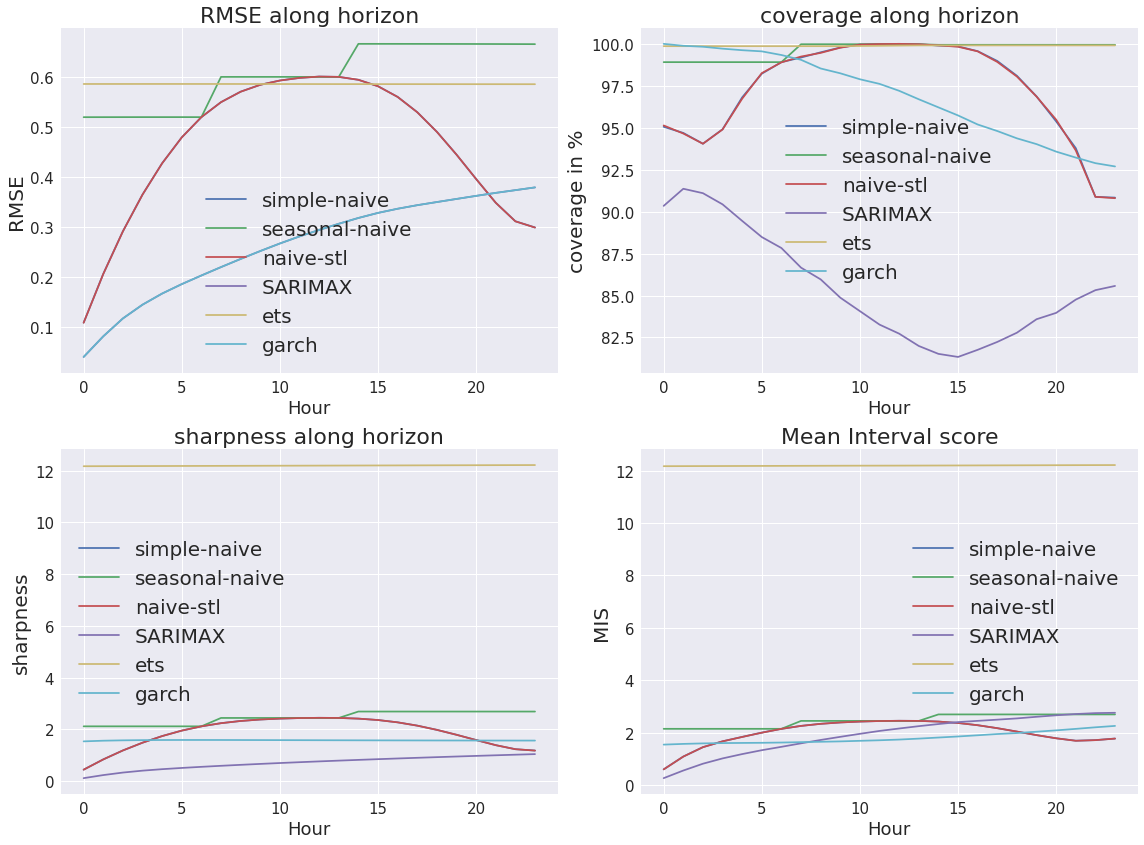

In [32]:
# plot metrics
# rmse_horizon, sharpness_horizon, coverage_horizon, mis_horizon, OUTPATH, title
plot.plot_metrics(
    rmse_values,
    sharpness_values,
    picp_values,
    mis_values,
    OUTDIR + "baselines",
)

We see that the best performing methods are on average, the Sarimax, Naive-STL, and seasonal naive. So we only go ahead and explore those ones in the next steps.

### Plot a historgramm of residuals

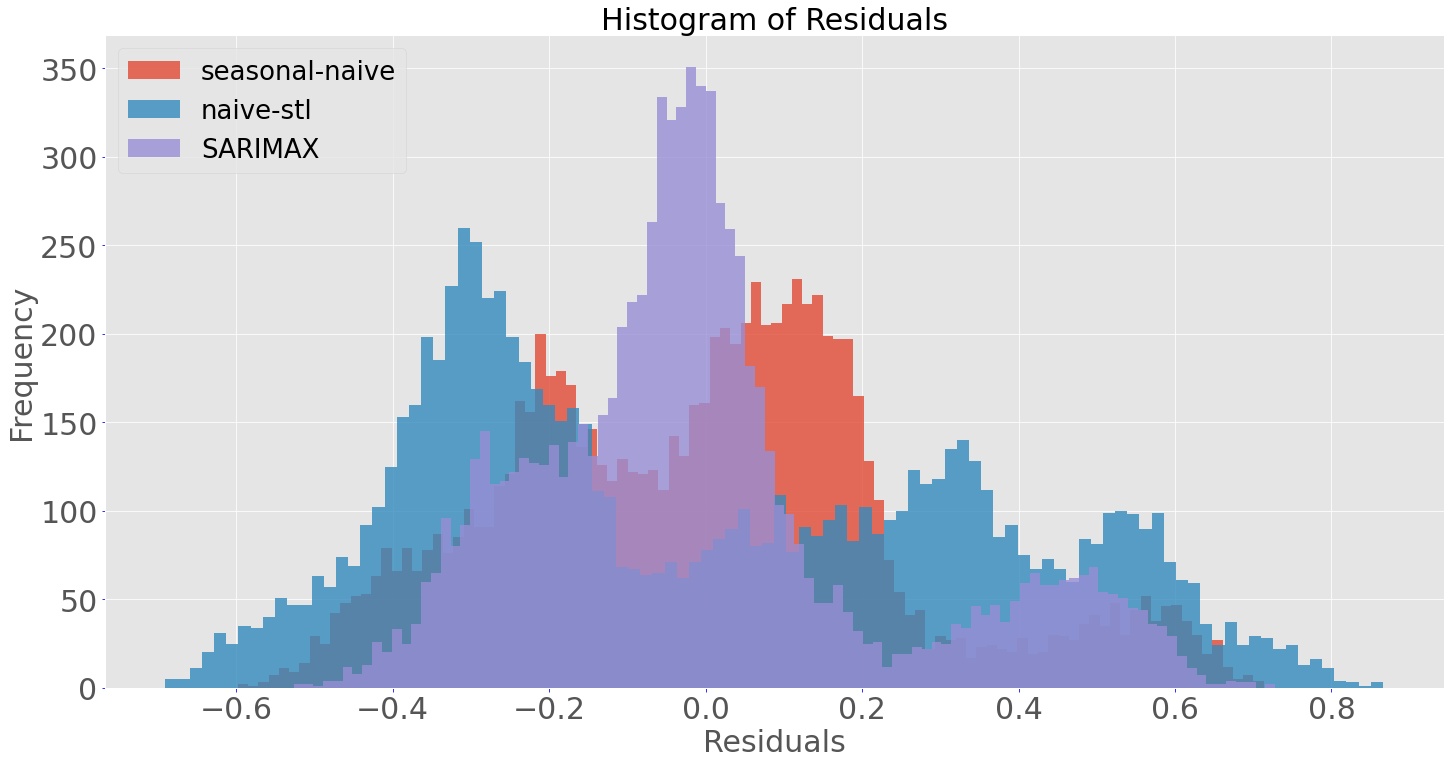

In [33]:
with torch.no_grad():
    plot_hist(
        targets=true_values,
        expected_values=forecasts,
        y_pred_upper=upper_limits,
        y_pred_lower=lower_limits,
        analyzed_metrics=["residuals"],
        sample_frequency=24,
        save_to_disc=OUTDIR + "baselines",
        method=['simple-naive','seasonal-naive', 'naive-stl', 'SARIMAX', 'ets', 'garch'],
        bins=100,
    )

## Now let us fetch forecasts from an RNN trained model
The steps to prepare the data, train the model and generate predictions are all exlained in the example notebook on day-ahead prediction with ProLoaF applied on the open power system data.
There the results are pickled, which we will load here:

In [34]:
RNN_targets = torch.load('RNN_true_values.pt')
RNN_forecasts = torch.load('RNN_forecasts.pt')
RNN_upper_limits = torch.load('RNN_upper_limits.pt')
RNN_lower_limits = torch.load('RNN_lower_limits.pt')

In [35]:
#transpose to same dimensions:
baseline_targets_transposed = true_values.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_forecasts_transposed = forecasts.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_upper_limits_transposed = upper_limits.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_lower_limits_transposed = lower_limits.transpose(1,2)[:,:,:len(RNN_forecasts)]

all_true_values = torch.cat((baseline_targets_transposed, RNN_targets.transpose(0,2)),0).transpose(1,2)
all_forecasts = torch.cat((baseline_forecasts_transposed, RNN_forecasts.transpose(0,2)),0).transpose(1,2)
all_upper_limits = torch.cat((baseline_upper_limits_transposed, RNN_upper_limits.transpose(0,2)),0).transpose(1,2)
all_lower_limits = torch.cat((baseline_lower_limits_transposed, RNN_lower_limits.transpose(0,2)),0).transpose(1,2)

In [36]:
all_methods = baseline_method
all_methods.append('RNN')

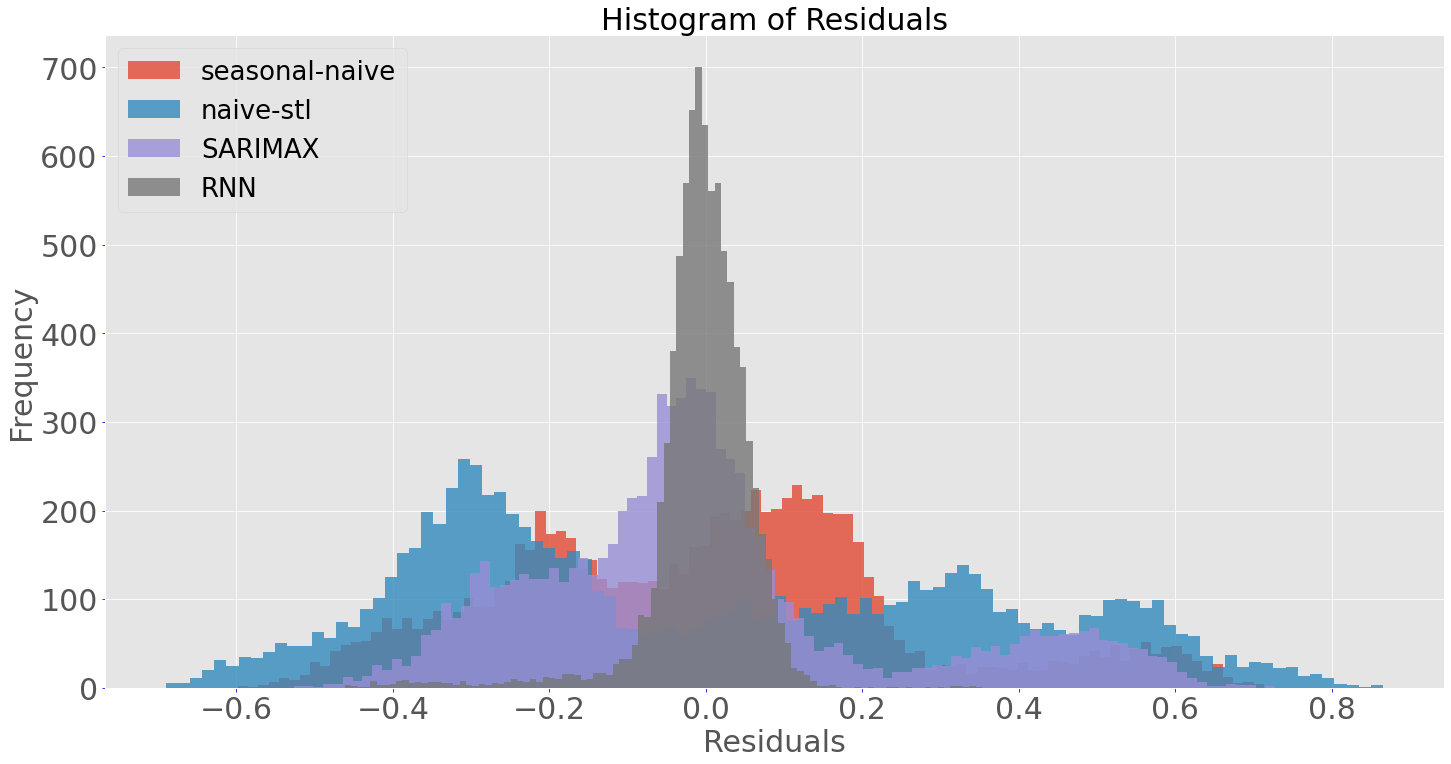

In [37]:
with torch.no_grad():
    plot_hist(
        targets=all_true_values,
        expected_values=all_forecasts,
        y_pred_upper=all_upper_limits,
        y_pred_lower=all_lower_limits,
        analyzed_metrics=["residuals"],
        sample_frequency=24,
        save_to_disc=OUTDIR + "baselines",
        method=all_methods,
        bins=100,
    )